# Importing Libraries

In [3]:
# Importing Relevant Libraries
import os, os.path
import importlib
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import qmc
import pyDOE2 as pyd
import seaborn as sns
from matplotlib.pyplot import plot, savefig
import time
import datetime 
from datetime import date
from pyomo.opt import SolverStatus, TerminationCondition
import matplotlib.ticker as mtick
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
import graphviz 
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import logging
from cmcrameri import cm # https://www.fabiocrameri.ch/ws/media-library/ce2eb6eee7c345f999e61c02e2733962/readme_scientificcolourmaps.pdf

# Source: https://danshiebler.com/2016-09-14-parallel-progress-bar/
from tqdm import tqdm
import concurrent.futures
from concurrent.futures import ProcessPoolExecutor, as_completed
import sys # Python "sys" documentation: https://docs.python.org/3/library/sys.html

In [4]:
# To reset the default parameters of matplotlib:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Importing data

In [28]:
# ------------------ Parameters not imported/computed ------------------
i = ['BECCS', 'A/R', 'SCS', 'BC', 'DACCS', 'EW', 'OA', 'DOCCS']
full_names = {'BECCS':'Bioenergy with Carbon \n Capture & Storage', 
              'A/R': 'Afforestation \n & Reforestation', 
              'SCS': 'Soil Carbon \n Sequestration', 
              'BC': 'Biochar', 
              'DACCS':'Direct Air Carbon \n Capture & Storage', 
              'EW': 'Enhanced Rock \n Weathering', 
              'OA': 'Ocean Alkalinisation', 
              'DOCCS':'Direct Ocean Carbon \n Capture & Storage'}
k1 = 0 # Value of first time period
delK = 5 # Time step of optimisation (i.e., length of each period)
N = 4 # Number of segments for piecewise linear approximation
first_year = 2020 # Year corresponding to first time period
last_year = 2100 # Year corresponding to last time period
T = int(1 + (last_year-first_year)/delK) # Number of time periods evaluated, equivalent to 17 if delK = 5 (i.e., 80 years)
k = list(range(k1,T))

# Color Map for later plotting
cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}

## Model input data

In [6]:
# If the kernel is restarted: run any of the "With sampling step / size" cells and then run this one
#today = date.today().strftime("%d.%m.%Y")
today = "15.08.2024"
df_input = pd.read_excel("Input_Output_Files/File Name_%s.xlsx" %today, index_col ='future_id')

# To separate all parameters (in df_input) vs the ones that change across futures (in df_LHS): saving the parameters from the original file
df = pd.read_excel("PortfolioFiles/Portfolio_Files_Latest/All data Step size.xlsx", index_col = "Parameter")
units = dict(zip(df.index, df.Unit)) # Save all units in a dictionary for later use
df = df[df.minimum != df.maximum]
df = df[['minimum','maximum']]
dict_ranges = df.T.to_dict('records')[0]

# If only the LHS table is wanted:
df_LHS = df_input[list(dict_ranges.keys())].T

# If only the Y_ref is wanted:
Initial_YRef = df_input[df_input.columns.intersection(['Yref_' + el for el in i])]
Initial_YRef.columns = [str(col).split('_')[1] for col in Initial_YRef.columns]
Initial_YRef = Initial_YRef.loc[0].to_dict()

n_lhs = len(df_LHS.T.index)-1 # "-1" because we added future 0 :)

df_LHS.head()

future_id,0,1,2,3,4,5,6,7,8,9,...,2991,2992,2993,2994,2995,2996,2997,2998,2999,3000
Energy_DACCS,4.7,4.700,10.000,6.467,10.000,6.467,4.7,8.233,4.700,6.467,...,8.233,8.233,4.700,10.000,10.000,8.233,6.467,10.000,10.000,4.7
Energy_DOCCS,2.5,8.300,8.300,2.500,6.367,8.300,8.3,6.367,2.500,6.367,...,8.300,8.300,8.300,4.433,2.500,2.500,2.500,6.367,2.500,2.5
Energy_EW,0.5,12.500,0.500,4.500,12.500,8.500,12.5,0.500,12.500,12.500,...,8.500,8.500,4.500,12.500,8.500,8.500,12.500,0.500,4.500,0.5
Energy_OA,0.7,4.767,2.733,6.800,2.733,2.733,6.8,2.733,4.767,2.733,...,4.767,6.800,4.767,2.733,4.767,2.733,0.700,4.767,2.733,0.7
EnergyL,2030.0,2045.000,2045.000,2030.000,2030.000,2045.000,2045.0,2050.000,2040.000,2050.000,...,2045.000,2030.000,2035.000,2050.000,2040.000,2030.000,2050.000,2050.000,2040.000,2040.0


In [7]:
Uncertainties = dict(zip(df_LHS.index.to_list(),['DACCS Energy Requirements','DOCCS Energy Requirements','EW Energy Requirements', 'OA Energy Requirements', 'Year at which energy becomes available for CDR',
'A/R Land Requirements','BECCS Land Requirements','Land Limit','A/R Experience Parameter','BC Experience Parameter','BECCS Experience Parameter','DACCS Experience Parameter',
'DOCCS Experience Parameter','EW Experience Parameter','OA Experience Parameter','SCS Experience Parameter','Removals Required (2020 - 2100)','A/R Maximum Potential', 'BC Maximum Potential', 'BECCS Maximum Potential',
'DACCS Maximum Potential', 'DOCCS Maximum Potential', 'EW Maximum Potential', 'OA Maximum Potential', 'SCS Maximum Potential', 'Annual Limit to Geological Injection']))
Uncertainties

{'Energy_DACCS': 'DACCS Energy Requirements',
 'Energy_DOCCS': 'DOCCS Energy Requirements',
 'Energy_EW': 'EW Energy Requirements',
 'Energy_OA': 'OA Energy Requirements',
 'EnergyL': 'Year at which energy becomes available for CDR',
 'Land_A/R': 'A/R Land Requirements',
 'Land_BECCS': 'BECCS Land Requirements',
 'LandL': 'Land Limit',
 'ER_A/R': 'A/R Experience Parameter',
 'ER_BC': 'BC Experience Parameter',
 'ER_BECCS': 'BECCS Experience Parameter',
 'ER_DACCS': 'DACCS Experience Parameter',
 'ER_DOCCS': 'DOCCS Experience Parameter',
 'ER_EW': 'EW Experience Parameter',
 'ER_OA': 'OA Experience Parameter',
 'ER_SCS': 'SCS Experience Parameter',
 'CDRRequired': 'Removals Required (2020 - 2100)',
 'Ymax_A/R': 'A/R Maximum Potential',
 'Ymax_BC': 'BC Maximum Potential',
 'Ymax_BECCS': 'BECCS Maximum Potential',
 'Ymax_DACCS': 'DACCS Maximum Potential',
 'Ymax_DOCCS': 'DOCCS Maximum Potential',
 'Ymax_EW': 'EW Maximum Potential',
 'Ymax_OA': 'OA Maximum Potential',
 'Ymax_SCS': 'SCS Max

## Model output data

In [8]:
#Reading aggregated results to csv:
#today = date.today().strftime("%d.%m.%Y")
today = "27.11.2024"

aggregated_results = pd.read_csv("Input_Output_Files/aggregated_results_%s.csv" %today, index_col ='future_id')
#results_in_future = aggregated_results[['Cumulative capacity','Annual Capacity','Removals per period','Costs per period (undiscounted)','End. Cumulative Costs']]

all_metrics_ranges = {key: [] for key in aggregated_results.columns.to_list()}
for metric in aggregated_results.columns:
    all_metrics_ranges[metric].append([aggregated_results[metric].min(),aggregated_results[metric].max()])

total_future = aggregated_results[['Removals','Costs']]
max_resources = aggregated_results[['Land','Energy','Water','Nitrogen','Phosphorous']]   
max_capacity = aggregated_results[i]

removed_per_CDR = aggregated_results[aggregated_results.columns.intersection([el+'_removed' for el in i])]
removed_per_CDR.columns = [str(col).split('_')[0] for col in removed_per_CDR.columns]

max_2050 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2050 for el in i])].T
max_2050.index = [str(col).split('_')[0] for col in max_2050.index]

max_2075 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2075 for el in i])].T
max_2075.index = [str(col).split('_')[0] for col in max_2075.index]

max_2100 = aggregated_results[aggregated_results.columns.intersection([el+'_%d' %2100 for el in i])].T
max_2100.index = [str(col).split('_')[0] for col in max_2100.index]

solved = aggregated_results.Solved.sum()

all_metrics_names = dict(zip(aggregated_results.columns.to_list(),['DACCS Energy Requirements','DOCCS Energy Requirements','EW Energy Requirements', 'OA Energy Requirements', 'Year at which energy becomes available for CDR',
'A/R Land Requirements','BECCS Land Requirements','Land Limit','A/R Experience Parameter','BC Experience Parameter','BECCS Experience Parameter','DACCS Experience Parameter',
'DOCCS Experience Parameter','EW Experience Parameter','OA Experience Parameter','SCS Experience Parameter','Removals Required (2020 - 2100)','A/R Maximum Potential', 'BC Maximum Potential', 'BECCS Maximum Potential',
'DACCS Maximum Potential', 'DOCCS Maximum Potential', 'EW Maximum Potential', 'OA Maximum Potential', 'SCS Maximum Potential', 'Annual Limit to Geological Injection','Solved Futures', 'Tons Removed', 'Discounted Cumulative Costs',
'Maximum Capacity of AR','Maximum Capacity of BC','Maximum Capacity of BECCS','Maximum Capacity of DACCS','Maximum Capacity of DOCCS', 'Maximum Capacity of EW', 'Maximum Capacity of OA', 'Maximum Capacity of SCS',
'Land used for CDR', 'Energy used for CDR','Water used for CDR', 'Nitrogen used for CDR', 'Phosphorous used for CDR','Maximum Capacity BECCS by 2050','Maximum Capacity A/R by 2050','Maximum Capacity SCS by 2050','Maximum Capacity BC by 2050','Maximum Capacity DACCS by 2050',
'Maximum Capacity EW by 2050','Maximum Capacity OA by 2050','Maximum Capacity DOCCS by 2050','Maximum Capacity BECCS by 2075','Maximum Capacity A/R by 2075','Maximum Capacity SCS by 2075','Maximum Capacity BC by 2075','Maximum Capacity DACCS by 2075',
'Maximum Capacity EW by 2075','Maximum Capacity OA by 2075','Maximum Capacity DOCCS by 2075','Maximum Capacity BECCS by 2100','Maximum Capacity A/R by 2100','Maximum Capacity SCS by 2100','Maximum Capacity BC by 2100','Maximum Capacity DACCS by 2100',
'Maximum Capacity EW by 2100','Maximum Capacity OA by 2100','Maximum Capacity DOCCS by 2100']))

all_metrics_units = dict(zip(aggregated_results.columns.to_list(),['GJ/tCO2','GJ/tCO2','GJ/tCO2','GJ/tCO2', 'year', 'ha/tCO2','ha/tCO2','ha',
'%','%','%','%','%','%','%','%','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2/yr','binary', 'tCO2', 'USD','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2','tCO2',
'ha', 'GJ','km3', 'Mt N', 'Mt P','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr',
'tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr','tCO2/yr']))

all_metrics_ranges = {key: [] for key in aggregated_results.columns.to_list()}
for metric in aggregated_results.columns:
    all_metrics_ranges[metric].append([aggregated_results[metric].min(),aggregated_results[metric].max()])

aggregated_results

,Energy_DACCS,Energy_DOCCS,Energy_EW,Energy_OA,EnergyL,Land_A/R,Land_BECCS,LandL,ER_A/R,ER_BC,...,OA_2100,DOCCS_2100,BECCS_removed,A/R_removed,SCS_removed,BC_removed,DACCS_removed,EW_removed,OA_removed,DOCCS_removed
future_id,,,,,,,,,,,,,,,,,,,,,
0,4.700,2.500,0.5,0.700,2030,0.07,0.040,200000000,-0.230,-0.050,...,6.982525e+08,0.0,2.730000e+07,1.500000e+11,3.300000e+10,1.050750e+10,1.725000e+11,2.000000e+10,1.396505e+10,10.0
1,4.700,8.300,12.5,4.767,2045,0.08,0.170,1000000000,-0.230,-0.033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.000,8.300,0.5,2.733,2045,0.08,0.170,600000000,-0.230,0.083,...,0.000000e+00,0.0,2.730000e+07,1.936790e+11,1.166000e+11,9.090750e+10,9.878603e+10,1.000000e+01,1.000000e+01,10.0
3,6.467,2.500,4.5,6.800,2030,0.07,0.170,400000000,-0.202,0.100,...,1.000000e+09,0.0,6.636388e+10,1.822000e+11,8.775000e+10,2.255070e+11,3.708050e+11,4.952163e+10,1.785220e+10,10.0
4,10.000,6.367,12.5,2.733,2030,0.07,0.040,600000000,-0.063,0.017,...,1.080000e+10,0.0,1.141960e+11,2.794000e+11,6.200000e+10,2.325750e+10,1.539640e+11,1.000000e+01,2.671830e+11,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2996,8.233,2.500,8.5,2.733,2030,0.09,0.105,700000000,-0.202,0.017,...,5.200000e+09,0.0,9.600568e+10,2.794000e+11,1.590000e+11,1.538070e+11,2.970480e+11,6.484983e+08,1.140900e+11,10.0
2997,6.467,2.500,12.5,0.700,2050,0.08,0.040,300000000,-0.174,-0.050,...,3.800000e+09,0.0,8.970591e+10,2.213270e+11,1.590000e+11,4.185750e+10,1.197780e+11,7.040105e+09,1.612920e+11,10.0
2998,10.000,6.367,0.5,4.767,2050,0.09,0.105,200000000,0.020,-0.017,...,1.220000e+10,0.0,2.730000e+07,1.625000e+11,1.000000e+11,3.900750e+10,1.487922e+10,1.081155e+10,1.727750e+11,10.0


# Plotting & Analysis included in Manuscript & Supplementary Information

## Summary Statistics

In [9]:
# ======================== Summary Statistics of max capacity of each CDR option by 2100 ======================== 
data = max_2100.T.copy()

# We can also compare output and input data: Ymax stores the input max potential
Ymax = pd.DataFrame() 
for CDR in i:
    Ymax[CDR] = aggregated_results.loc[:,'Ymax_%s' %CDR].div(1e9)
    
# This is because the dataframes were defined as: max_time = (Max capacity in indicated time period) - (Initial Capacity Installed) 
for CDR in data.columns:
    data.loc[:,CDR] += Initial_YRef[CDR]
        
summary = data.div(1e9).describe(include = 'all')
summary.loc['median'] = data.div(1e9).median()

summary.loc['input_max'] = Ymax.max()
summary.loc['input_min'] = Ymax.min()
summary.loc['input_range'] = summary.loc['input_max'] - summary.loc['input_min']

summary.loc['IQR'] = summary.loc['75%']-summary.loc['25%']

# Computing and normalising different metrics 
summary.loc['IQR_norm'] = summary.loc['IQR'].div(summary.loc['IQR'].max()) #IQR divided by largest IQR
summary.loc['std_norm'] = summary.loc['std'].div(summary.loc['std'].max()) #std divided by largest std
summary.loc['median_to_max_norm'] = (summary.loc['max']-data.div(1e9).median())/summary.loc['max'] # (output max - median)/(output max) 
summary.loc['median_to_max_range'] = (summary.loc['max']-data.div(1e9).median())/(summary.loc['max']-summary.loc['min']) # (output max - median)/(output max - output min) 
summary.loc['median_to_max_norm_input'] = (summary.loc['max']-data.div(1e9).median())/summary.loc['input_max'] # (output max - median)/(input max) 

for CDR in i:
    summary.loc['IQR_norm_2',CDR] = summary.loc['IQR',CDR]/summary.loc['max',CDR] 

    data = max_2100.T[CDR]
    a = data.to_numpy()
    a = a[~np.isnan(a)]

    summary.loc['median_abs_deviation',CDR] = stats.median_abs_deviation(a, axis = 0)/(1E9)

summary.loc['median_abs_deviation_norm'] = summary.loc['median_abs_deviation'].div(summary.loc['median_abs_deviation'].max())

#pd.option_context('display.float_format', '{:,.2f}'.format)
pd.options.display.float_format = "{:,.2f}".format
                 
summary

,BECCS,A/R,SCS,BC,DACCS,EW,OA,DOCCS
count,"2,687.00","2,687.00","2,687.00","2,687.00","2,687.00","2,687.00","2,687.00","2,687.00"
mean,2.23,3.36,1.47,2.81,6.49,1.52,4.77,0.07
std,2.35,0.88,0.55,1.97,3.22,1.41,4.33,0.63
min,0.00,1.98,0.60,0.00,0.00,0.00,0.00,0.00
25%,0.04,2.43,0.98,0.93,4.00,0.00,0.00,0.00
50%,1.79,3.29,1.55,2.82,6.50,1.85,3.80,0.00
75%,3.54,4.40,1.93,4.71,8.61,2.80,8.00,0.00
max,10.00,4.40,2.31,5.97,12.50,3.80,13.60,9.10
median,1.79,3.29,1.55,2.82,6.50,1.85,3.80,0.00
input_max,11.41,5.87,2.31,5.97,18.50,3.80,13.60,9.10


## Simplified Portfolios by Removals

If a future is deemed feasible by the solver, the optimisation model outputs a CDR portfolio capacity expansion plan at a 5-year increment. This output is highly granular, challenging the exact comparability of portfolio compositions. For this reason, model outputs are here converted into "simplified" porfolios" by grouping capacity of CDR option deployed into 4 bins and 3 different time periods (i.e., 2050, 2075, 2100).

- "bins" defines the ranges for the max removals level of the simplified portfolios. Index = CDR options, columns = 1,2,3,4 
    - Bin 1: $Y_i^{ini}·\Delta K$
    - Bins 2 & 3: equally spaced
    - Bin 4: $B^{max}_{i, \ output}$
- "simplified" has a multiindex: future ID, CDR option. Columns = [2050, 2075, 2100].

### Defining Bins

In [10]:
# Creating bins for simplified portfolios: find maximum experience achieved for each CDR across all futures $Z^{max}_{i,output}$
# Initial_YRef: Dictionary with Initial Y ref values
data = removed_per_CDR.copy()

n_bins = 4
B_max = pd.DataFrame(data.max()) # Outputs the largest experience achieved for each CDR option across futures

bins = pd.DataFrame(index=i, columns = list(range(1,n_bins+1)))
for column in bins.columns:
    for CDR in i:
        mini = math.ceil(data.min()[CDR])
        if CDR == 'EW': mini = 10.5
        maxi = B_max.loc[CDR,0]
        if column == 1:
            bins.loc[CDR, column] = mini
        elif column == n_bins:
            bins.loc[CDR, column] = math.ceil(maxi)
        else:
            bins.loc[CDR, column] = math.ceil(mini+(column-1)*(maxi - mini)/n_bins)
bins

,1,2,3,4
BECCS,27300000,139277225000,278527150000,557027000000
A/R,59400000000,114400000000,169400000000,279400000000
SCS,12000000010,52312500008,92625000005,173250000000
BC,7500000,106394875000,212782250000,425557000000
DACCS,150000,110093862500,220187575000,440375000000
EW,10.50,58667750008,117335500006,234671000000
OA,10,138381750008,276763500005,553527000000
DOCCS,10,57541000008,115082000005,230164000000


### Creating table with simplified portfolios for 1 time period

Infeasible futures ("NaN") have been dropped.

In [11]:
# Create a table with max capacity per CDR option per future for 3 different time periods

simplified = pd.DataFrame()

for futureID in range(0,n_lhs+1):
    results_in_f = pd.DataFrame()
    results_in_f.index = pd.MultiIndex.from_tuples([(futureID, i[n]) for n in range(0, len(i))],names=['future_id','CDR_opt'])
    for CDR in i:
        if np.isnan(removed_per_CDR.loc[futureID,CDR]) == True:
            results_in_f.loc[(futureID,CDR),2100] = np.nan
        else:
            bin_n = 1
            found = False
            while found == False:
                if removed_per_CDR.loc[futureID,CDR] <= bins.loc[CDR, bin_n]:
                    found = True
                    results_in_f.loc[(futureID, CDR),2100] = bins.loc[CDR, bin_n]
                else:
                    bin_n += 1

    simplified = pd.concat([simplified,results_in_f])

simplified = simplified.dropna(axis=0, how="all")
simplified

2100
future_id CDR_opt                   
0         BECCS        27,300,000.00
          A/R     169,400,000,000.00
          SCS      52,312,500,008.00
          BC      106,394,875,000.00
          DACCS   220,187,575,000.00
...                              ...
3000      BC      106,394,875,000.00
          DACCS   440,375,000,000.00
          EW       58,667,750,008.00
          OA      138,381,750,008.00
          DOCCS                10.00

[21496 rows x 1 columns]

In [12]:
# Create a table with max capacity per CDR option per future for 3 different time periods

simplified = pd.DataFrame()

for futureID in range(0,n_lhs+1):
    results_in_f = pd.DataFrame()
    results_in_f.index = pd.MultiIndex.from_tuples([(futureID, i[n]) for n in range(0, len(i))],names=['future_id','CDR_opt'])
    for CDR in i:
        if np.isnan(data.loc[futureID,CDR]) == True:
            results_in_f.loc[(futureID,CDR),2100] = np.nan
        else:
            bin_n = 1
            found = False
            while found == False:
                if data.loc[futureID,CDR] <= bins.loc[CDR, bin_n]:
                    found = True
                    results_in_f.loc[(futureID, CDR),2100] = bins.loc[CDR, bin_n]
                else:
                    bin_n += 1

    simplified = pd.concat([simplified,results_in_f])

simplified = simplified.dropna(axis=0, how="all")
simplified

2100
future_id CDR_opt                   
0         BECCS        27,300,000.00
          A/R     169,400,000,000.00
          SCS      52,312,500,008.00
          BC      106,394,875,000.00
          DACCS   220,187,575,000.00
...                              ...
3000      BC      106,394,875,000.00
          DACCS   440,375,000,000.00
          EW       58,667,750,008.00
          OA      138,381,750,008.00
          DOCCS                10.00

[21496 rows x 1 columns]

### Identifying repeated portfolios

Here the output dataframe "simplified_names" has one row per future, rather than a multi-index as for the "simplified" dataframe. Each case includes a list with the portfolio description as a string. This way, duplicates can easily be identified.

In [13]:
simplified_names = pd.DataFrame()
n = 2100
for futureID, CDR in simplified.groupby(level=0):
    results_in = pd.DataFrame()
    #for n in [2050, 2075, 2100]:
    results_in.loc[futureID,n] = str(list(simplified.loc[(futureID),n].to_dict().items()))       
    
    # Add column with cumulative removals per future ID 
    results_in.loc[futureID,'GtCO2'] = aggregated_results.loc[futureID, 'Removals']/(1e9)
    simplified_names = pd.concat([simplified_names,results_in])
    
simplified_names
# The index of 'simplified_names' is the future_ID

,2100,GtCO2
0,"[('BECCS', 27300000.0), ('A/R', 169400000000.0...",400.00
2,"[('BECCS', 27300000.0), ('A/R', 279400000000.0...",500.00
3,"[('BECCS', 139277225000.0), ('A/R', 2794000000...","1,000.00"
4,"[('BECCS', 139277225000.0), ('A/R', 2794000000...",900.00
5,"[('BECCS', 139277225000.0), ('A/R', 2794000000...",700.00
...,...,...
2996,"[('BECCS', 139277225000.0), ('A/R', 2794000000...","1,100.00"
2997,"[('BECCS', 139277225000.0), ('A/R', 2794000000...",800.00
2998,"[('BECCS', 27300000.0), ('A/R', 169400000000.0...",500.00
2999,"[('BECCS', 139277225000.0), ('A/R', 2794000000...",800.00


In [14]:
# Creating a dataframe that counts how many times a portfolio is repeated:
simple_portfolios_2100 = pd.DataFrame(simplified_names[2100].value_counts())

year = 2100
# For each time period:
#for time in [simple_portfolios_2050, simple_portfolios_2075, simple_portfolios_2100]:
for time in [simple_portfolios_2100]:    
    number = 1
    # For each portfolio (row) in "simple_portfolios_":
    for portfolio in time.index:
        repeated = simplified_names[year].isin([portfolio])
        # find the index of the first occurrence of 'portfolio' in the DataFrame "simplified_names"
        time.loc[portfolio,"Example_FutureID"] = repeated.idxmax() # 'idxmax' Return index of first occurrence of maximum over requested axis.
                
        repeated = list(repeated[repeated].index)  # List on futureIDs that have the occurrence 'portfolio'
        maxi = 450
        mini = 1100
        for futureID in repeated:
            removed = total_future.loc[futureID,"Removals"]/1e9
            if removed <= mini:
                mini = removed
            if removed >= maxi:
                maxi = removed
        
        time.loc[portfolio,"Removals_Min"] = mini 
        time.loc[portfolio,"Removals_Max"] = maxi
        if number <= 4:
            time.loc[portfolio,"Portfolio_ID"] = str(year)+str("_")+str(number)
        else: 
            time.loc[portfolio,"Portfolio_ID"] = str(year)+str("_other")

        number += 1

simple_portfolios_2100.head(8)

,2100,Example_FutureID,Removals_Min,Removals_Max,Portfolio_ID
"[('BECCS', 139277225000.0), ('A/R', 279400000000.0), ('SCS', 173250000000.0), ('BC', 106394875000.0), ('DACCS', 220187575000.0), ('EW', 58667750008.0), ('OA', 138381750008.0), ('DOCCS', 10.0)]",31,282.00,500.00,"1,000.00",2100_1
"[('BECCS', 139277225000.0), ('A/R', 279400000000.0), ('SCS', 173250000000.0), ('BC', 106394875000.0), ('DACCS', 220187575000.0), ('EW', 10.5), ('OA', 138381750008.0), ('DOCCS', 10.0)]",26,142.00,500.00,800.00,2100_2
"[('BECCS', 139277225000.0), ('A/R', 279400000000.0), ('SCS', 173250000000.0), ('BC', 106394875000.0), ('DACCS', 220187575000.0), ('EW', 58667750008.0), ('OA', 10.0), ('DOCCS', 10.0)]",25,71.00,500.00,800.00,2100_3
"[('BECCS', 139277225000.0), ('A/R', 169400000000.0), ('SCS', 92625000005.0), ('BC', 7500000.0), ('DACCS', 220187575000.0), ('EW', 10.5), ('OA', 10.0), ('DOCCS', 10.0)]",24,188.00,400.00,500.00,2100_4
"[('BECCS', 139277225000.0), ('A/R', 279400000000.0), ('SCS', 92625000005.0), ('BC', 106394875000.0), ('DACCS', 220187575000.0), ('EW', 58667750008.0), ('OA', 138381750008.0), ('DOCCS', 10.0)]",24,26.00,500.00,800.00,2100_other
"[('BECCS', 139277225000.0), ('A/R', 279400000000.0), ('SCS', 92625000005.0), ('BC', 106394875000.0), ('DACCS', 220187575000.0), ('EW', 10.5), ('OA', 138381750008.0), ('DOCCS', 10.0)]",23,27.00,500.00,800.00,2100_other
"[('BECCS', 27300000.0), ('A/R', 169400000000.0), ('SCS', 92625000005.0), ('BC', 7500000.0), ('DACCS', 220187575000.0), ('EW', 10.5), ('OA', 10.0), ('DOCCS', 10.0)]",22,331.00,400.00,450.00,2100_other
"[('BECCS', 139277225000.0), ('A/R', 279400000000.0), ('SCS', 173250000000.0), ('BC', 212782250000.0), ('DACCS', 220187575000.0), ('EW', 58667750008.0), ('OA', 138381750008.0), ('DOCCS', 10.0)]",20,24.00,700.00,"1,000.00",2100_other


#### Based on Removals required

In [15]:
year = 2100
removals_interested = [400,600,800,1100]
number_per = 2

per_removals = pd.DataFrame()
per_removals.index = pd.MultiIndex.from_product([removals_interested, list(range(1,number_per+1))], names=["GtCO2", "Rank"])

for Gt in removals_interested:
#for Gt in [400]:
    # Find the subset of portfolios that meet the GtCO2 of the "per_removals" index Gt
    find = simplified_names[simplified_names.GtCO2==Gt][year].value_counts()
    for n in range(1,number_per+1):
        name = pd.DataFrame(find).index[n-1]
        per_removals.loc[(Gt,n), 'Portfolio'] = name # Save the portfolio name
        per_removals.loc[(Gt,n), 'Count'] = find[n-1] # Save the number of times it is repeated
        per_removals.loc[(Gt,n), 'Example_FutureID'] = simplified_names[(simplified_names.GtCO2==Gt) & (simplified_names[2100] == name)].index.to_list()[n-1] # Save a future ID to plot

per_removals

Portfolio  Count  \
GtCO2 Rank                                                             
400   1     [('BECCS', 27300000.0), ('A/R', 169400000000.0...  22.00   
      2     [('BECCS', 139277225000.0), ('A/R', 1694000000...  20.00   
600   1     [('BECCS', 139277225000.0), ('A/R', 2794000000...  14.00   
      2     [('BECCS', 139277225000.0), ('A/R', 2794000000...  12.00   
800   1     [('BECCS', 139277225000.0), ('A/R', 2794000000...  10.00   
      2     [('BECCS', 139277225000.0), ('A/R', 2794000000...   8.00   
1100  1     [('BECCS', 139277225000.0), ('A/R', 2794000000...   8.00   
      2     [('BECCS', 139277225000.0), ('A/R', 2794000000...   5.00   

            Example_FutureID  
GtCO2 Rank                    
400   1               331.00  
      2               438.00  
600   1               136.00  
      2               265.00  
800   1                59.00  
      2             2,196.00  
1100  1               364.00  
      2             1,233.00

### Plotting

In [30]:
# ================ TRANSPARENCY DEFINED BY METRIC ================
order_by = 'median_abs_deviation_norm' # Order in which we would like to plot the technologies below median_abs_deviation_norm
define_color = summary.loc[order_by].to_dict() 

cmap=plt.get_cmap('Set2')
color_dict = {'BECCS':cmap(0.8), 'A/R':cmap(0.1), 'SCS':cmap(0.9), 'BC':cmap(0.2), 'DACCS':cmap(0.7), 'EW':cmap(0.3), 'OA':cmap(0.4), 'DOCCS':cmap(0.5)}
color_dict_norm = {}
mapping = {k: v for k, v in sorted(define_color.items(), key=lambda item: item[1])}

handles_plot= []
labels_plot = []
for CDR in mapping.keys():
    if CDR == 'DOCCS':
        color_dict_norm[CDR] = color_dict[CDR]
    else:
        x = list(color_dict[CDR])
        x[3] = 1.09-summary.loc[order_by,CDR]
        color_dict_norm[CDR] = tuple(x)
    #if CDR != 'DOCCS': 
        #handles_plot += [mpatches.Patch(color=color_dict_norm[CDR], label=CDR)]        
        handles_plot += [mpatches.Patch(color=color_dict[CDR], label=CDR)]
        labels_plot += [full_names[CDR]]
#color_dict_norm

In [ ]:
# ================ COLOUR DEFINED BY METRIC ================
order_by = 'std' # Order in which we would like to plot the technologies below --> 'std_norm'
define_color = summary.loc[order_by].to_dict() 

# Normalising so that the smallest value is 0 and the max 1
raw = list(define_color.values())
norm = (raw-np.min(raw))/(np.max(raw[:-1])-np.min(raw)) # The raw[:-1] is to remove DOCCS, as we are not plotting it but it has a large effect on the colours
n=0
for CDR in define_color:
    define_color[CDR] = norm[n]
    n +=1

cmap=cm.vik

color_dict_norm = {}
handles_plot= []
labels_plot = []
mapping = {k: v for k, v in sorted(summary.loc[order_by].to_dict().items(), key=lambda item: item[1])}

for CDR in mapping.keys():
    #color_dict_norm[CDR] = cmap(summary.loc[order_by,CDR])
    color_dict_norm[CDR] = cmap(define_color[CDR])
    if CDR != 'DOCCS': 
        handles_plot += [mpatches.Patch(color=color_dict_norm[CDR], label=CDR)]
        labels_plot += [full_names[CDR]]
        #labels_plot += [CDR]

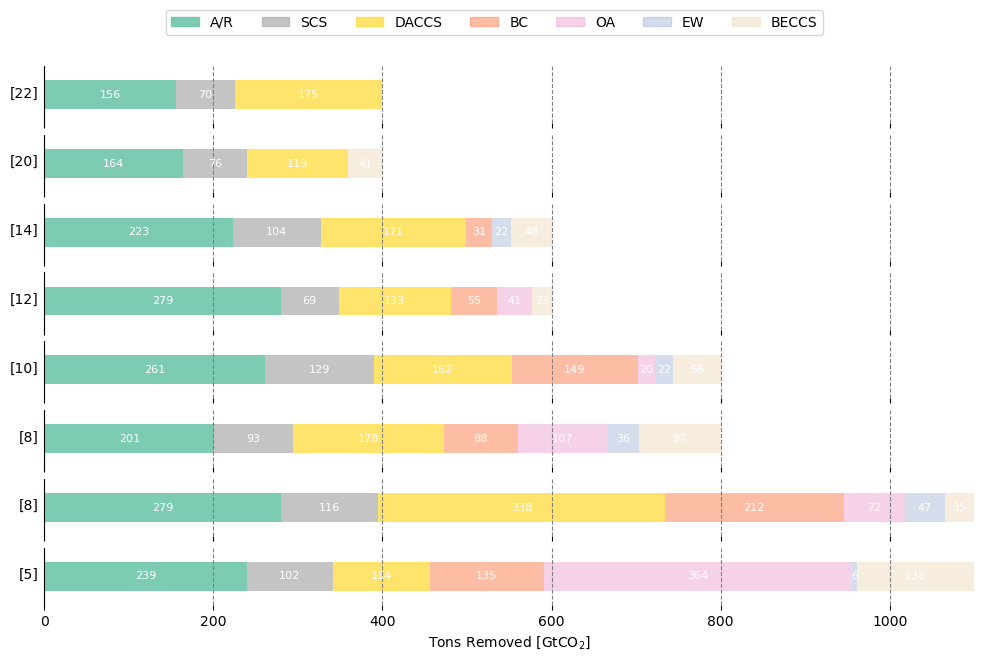

In [46]:
n_cols = 1
n_rows = number_per*len(removals_interested)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(12,7))

row = 0
col = 0

# Futures and data to plot
futures = per_removals['Example_FutureID'].to_list()

for futureID in futures:
    data = pd.DataFrame(removed_per_CDR.loc[futureID]).div(1e9)
    key = data.index.map(mapping)
    data = data.iloc[key.argsort()].T
    #data = pd.DataFrame(simplified.loc[futureID][2100]).div(1e9).T    
    
    AX = axes[row]
    ax_y = data.plot.barh(ax=AX,color=color_dict_norm, stacked=True, label = 2100, legend = False)
    #AX.axis("off")
    for rect in AX.patches: # .patches is everything inside of the chart, lines and rectangles and circles and stuff. In this case we only have rectangles!
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # Use 'width' if horizontal bars, 'height' if vertical bars
        label_text = round(width,0)

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        if label_text >0:
            AX.text(label_x, label_y, '%i' %label_text, ha='center', va='center', size=8, color = 'white') 
        
        AX.yaxis.offsetText.set_fontsize(8)
        AX.spines[['right', 'top','bottom']].set_visible(False)
        AX.xaxis.grid(color='gray', linestyle='dashed')
    
    AX.set_yticks([])
    AX.set_ylabel(ylabel='[%i]'%per_removals.loc[per_removals['Example_FutureID'] == futureID, 'Count'], fontsize = 10, rotation = 'horizontal', ha='right',y=height-0.1)

    if row == n_rows-1: AX.set_xlabel(xlabel='Tons Removed [GtCO$_2$]', fontsize = 10)
    if col == n_cols-1:
        col = 0
        row += 1
    else: col += 1

fig.legend(handles_plot, labels_plot, fontsize = 10, loc='upper center', bbox_to_anchor=(0.5, 0.97),ncol=8)

plt.show()    
plt.close('all')

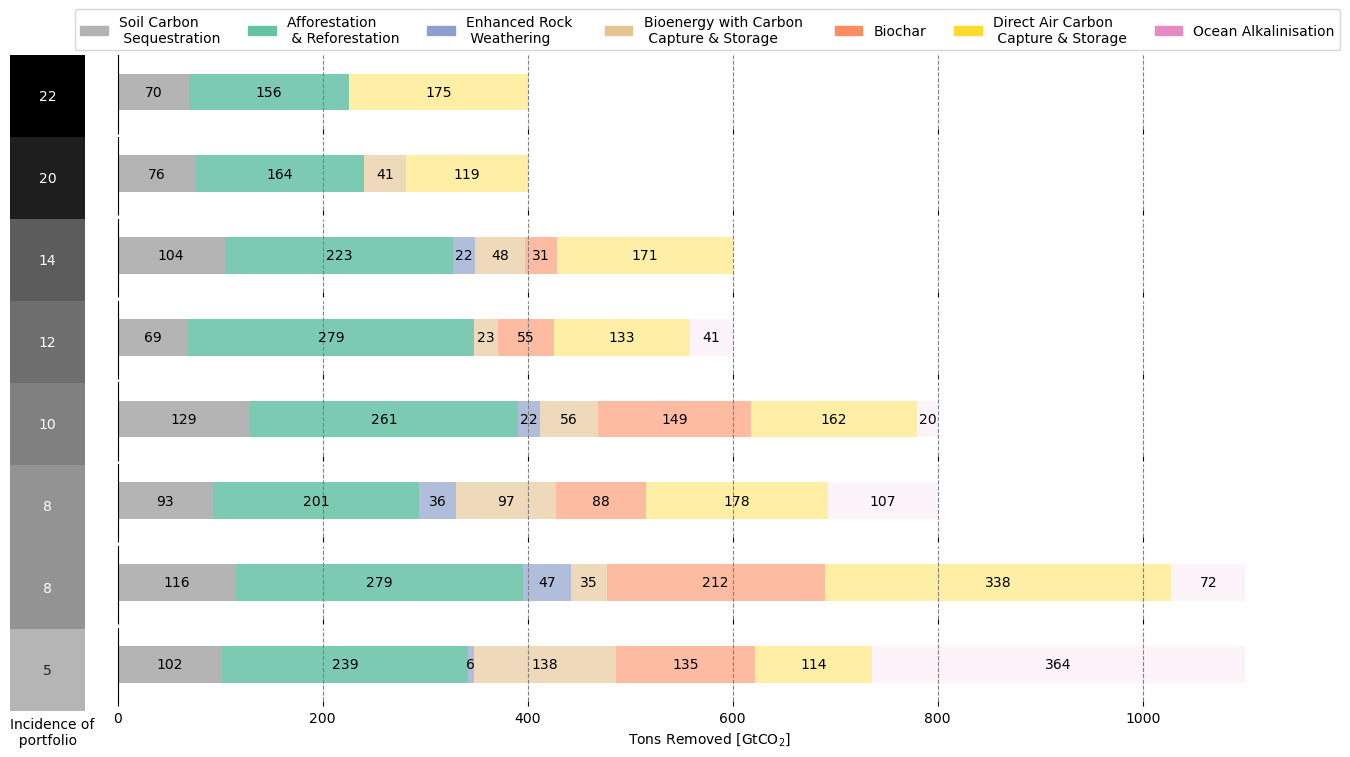

In [33]:
n_cols = 1
n_rows = number_per*len(removals_interested)
#fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(7,7))

fig = plt.figure(layout='constrained', figsize=(13, 7))
subfigs = fig.subfigures(1, 2, wspace=0.03, width_ratios=[0.07, 1])

row = 0
col = 0

# Futures and data to plot
futures = per_removals['Example_FutureID'].to_list()

axes = subfigs[1].subplots(nrows=n_rows, ncols=n_cols, sharex=True)

for futureID in futures:
    data = pd.DataFrame(removed_per_CDR.loc[futureID]).div(1e9)
    key = data.index.map(mapping)
    data = data.iloc[key.argsort()].T
    #data = pd.DataFrame(simplified.loc[futureID][2100]).div(1e9).T    
    
    AX = axes[row]
    ax_y = data.plot.barh(ax=AX,color=color_dict_norm, stacked=True, label = 2100, legend = False)
    #AX.axis("off")
    for rect in AX.patches: # .patches is everything inside of the chart, lines and rectangles and circles and stuff. In this case we only have rectangles!
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # Use 'width' if horizontal bars, 'height' if vertical bars
        label_text = round(width,0)

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        if label_text >0:
            AX.text(label_x, label_y, '%i' %label_text, ha='center', va='center', size=10, color = 'black') 
        
        AX.yaxis.offsetText.set_fontsize(8)
        AX.spines[['right', 'top','bottom']].set_visible(False)
        AX.xaxis.grid(color='gray', linestyle='dashed')
    
    AX.set_yticks([])
    #AX.set_ylabel(ylabel='[%i]'%per_removals.loc[per_removals['Example_FutureID'] == futureID, 'Count'], fontsize = 10, rotation = 'horizontal', ha='right',y=height-0.1)

    if row == n_rows-1: AX.set_xlabel(xlabel='Tons Removed [GtCO$_2$]', fontsize = 10)
    if col == n_cols-1:
        col = 0
        row += 1
    else: col += 1

subfigs[1].legend(handles_plot, labels_plot, fontsize = 10, loc='upper center', bbox_to_anchor=(0.5, 1.07),ncol=8)

ax = subfigs[0].subplots(1, 1)
ax = sns.heatmap(pd.DataFrame(per_removals.Count.values), annot=True, cmap=cm.grayC_r, vmin=0, cbar=False) # acton_r
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel(xlabel='Incidence of \n  portfolio', loc='left')

plt.show()    
plt.close('all')

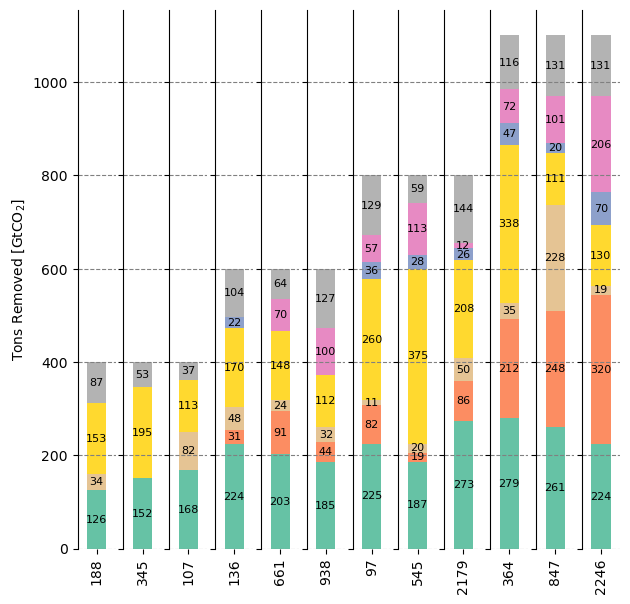

In [451]:
n_cols = number_per*len(removals_interested)
n_rows = 1
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharey=True, figsize=(7,7))

row = 0
col = 0
#for Gt, rank in per_removals.groupby(level=0):
futures = per_removals['Example_FutureID'].to_list()

for futureID in futures:
    #label_bar(pd.DataFrame(simplified.loc[futureID][2100]).div(1e9).T,axes[col])
    label_bar(pd.DataFrame(removed_per_CDR.loc[futureID]).div(1e9).T,axes[col])

    #axes[row,col].set_title('%s GtCO2' %Gt)
    if col == 0: axes[col].set_ylabel(ylabel='Tons Removed [GtCO$_2$]', fontsize = 10)

    if col == n_cols-1:
        col = 0
        row += 1
    else: col += 1

plt.show()    
plt.close('all')

In [459]:
def label_bar(data, AX):
    ax_y = data.plot.bar(ax=AX,color=color_dict,stacked=True, label = 2100, legend = False)
    #AX.axis("off")
    for rect in AX.patches: # .patches is everything inside of the chart, lines and rectangles and circles and stuff. In this case we only have rectangles!
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The width of the bar is also not pixels, it's the
        # number of animals. So we can use it as the label!
        label_text = round(height,0)

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        if label_text >0:
            AX.text(label_x, label_y, '%i' %label_text, ha='center', va='center', size=8) 
        
        #AX.tick_params(axis='x', labelsize = 9)
        #axes[row,col].ticklabel_format(axis='y', style='sci', scilimits=(4,5))
        AX.yaxis.offsetText.set_fontsize(8)
        AX.spines[['right', 'top','bottom']].set_visible(False)
        #AX.set_axisbelow(True)
        AX.yaxis.grid(color='gray', linestyle='dashed')
    
    return AX

def label_barh(data, AX):
    ax_y = data.plot.barh(ax=AX,color=color_dict, stacked=True, label = 2100, legend = False)
    #AX.axis("off")
    for rect in AX.patches: # .patches is everything inside of the chart, lines and rectangles and circles and stuff. In this case we only have rectangles!
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # The width of the bar is also not pixels, it's the
        # number of animals. So we can use it as the label!
        label_text = round(width,0)

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        if label_text >0:
            AX.text(label_x, label_y, '%i' %label_text, ha='center', va='center', size=8) 
        
        #AX.tick_params(axis='x', labelsize = 9)
        #axes[row,col].ticklabel_format(axis='y', style='sci', scilimits=(4,5))
        AX.yaxis.offsetText.set_fontsize(8)
        AX.spines[['right', 'top','bottom']].set_visible(False)
        #AX.set_axisbelow(True)
        AX.xaxis.grid(color='gray', linestyle='dashed')
    
    return AX


#### For scenarios

In [31]:
dataframe = max_2100.T.copy()
# This is because the dataframes were defined as: max_time = (Max capacity in indicated time period) - (Initial Capacity Installed) 
for CDR in dataframe.columns:
    dataframe.loc[:,CDR] += Initial_YRef[CDR]
    
# ======================= Summary Statistics =======================
parameters = {'OA_2100':[1,0]}

for parameter in list(parameters.keys()): 
    metrics_of_interest = extract_range(all_metrics_ranges,metric_interest=parameter,minimum=parameters[parameter][0],maximum=parameters[parameter][1])
    
    # ================================== Identifying Futures of Interest ==================================
    list_of_futures = []
    remaining_futures = aggregated_results.copy()
    for metric in metrics_of_interest:
        for futureID in remaining_futures.index:
            value = remaining_futures.loc[futureID, metric]
            if (value >= metrics_of_interest[metric][0][0]) & (value <= metrics_of_interest[metric][0][1]):
                list_of_futures += [futureID]
            else:
                remaining_futures = remaining_futures.drop(futureID)
    list_of_futures_in = remaining_futures.index.to_list()
    list_of_futures_out = list(set(aggregated_results.index.to_list()) - set(list_of_futures_in)) # List of futures that are outside ranges specified in "metrics_of_interest"

    for futureID in list_of_futures_out: dataframe = dataframe[dataframe.index != futureID]

summary_scenario = dataframe.div(1e9).describe(include = 'all')
summary_scenario.loc['median'] = dataframe.div(1e9).median()
summary_scenario.loc['IQR'] = summary_scenario.loc['75%']-summary_scenario.loc['25%']

#Normalising the IQR based on largest value
summary_scenario.loc['IQR_norm'] = summary_scenario.loc['IQR'].div(summary.loc['IQR'].max()) # Note that we are dividing by the general summary
summary_scenario.loc['std_norm'] = summary_scenario.loc['std'].div(summary.loc['std'].max()) # Note that we are dividing by the general summary
#summary_scenario.loc['median_to_max_norm'] = (summary_scenario.loc['max']-summary_scenario.loc['median'])/summary_scenario.loc['max'] # (output max - median)/(output max) 
summary_scenario.loc['median_to_max_norm'] = (summary.loc['max']-summary_scenario.loc['median'])/summary.loc['max'] # NOTE: using max from ensemble of all futures 

#pd.option_context('display.float_format', '{:,.2f}'.format)
print("Summary of results for scenarios based on parameters %s" %parameters.keys())                  
summary_scenario

NameError: name 'extract_range' is not defined

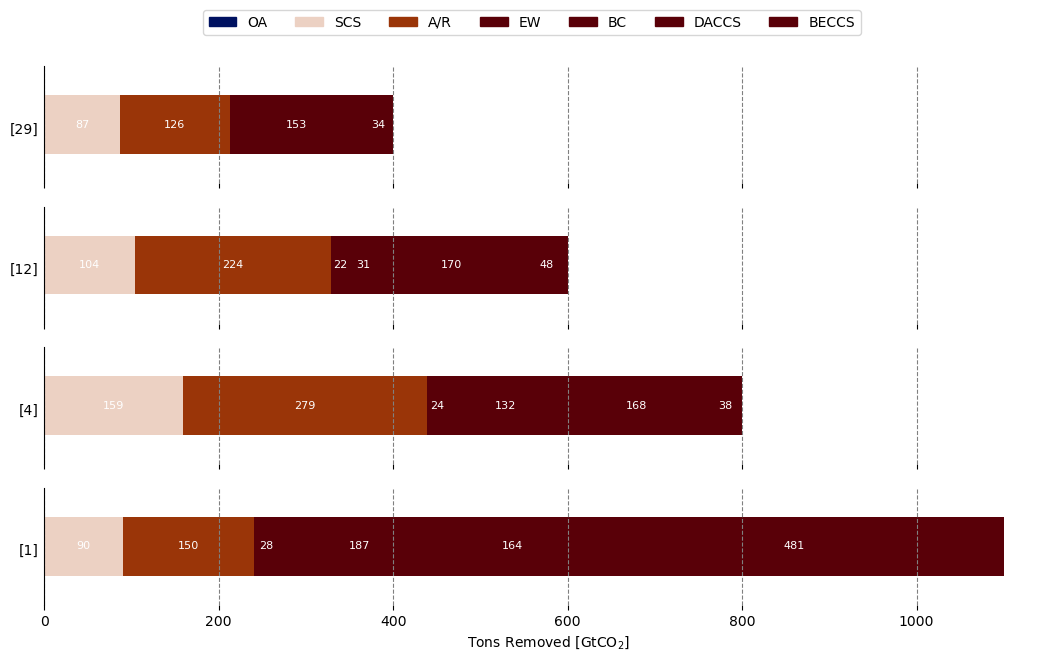

In [1149]:
'''
From Cell: Violin Charts > Scenarios > 3 Scenarios: we take list_of_futures_out
We simply keep only the futures that meet our scenario definition, and do the same analysis

NOTE: for the colors, we are using the std from the scenario subset, which ofc shows OA as less risky because the range is much lower. 
'''

# ================================================================================================================
# Keeping only the futures that meet our scenario definition
for futureID in list_of_futures_out: simplified_names = simplified_names[simplified_names.index != futureID] 

# ================================================================================================================
simple_portfolios_2100 = pd.DataFrame(simplified_names[2100].value_counts())

year = 2050
# For each time period:
#for time in [simple_portfolios_2050, simple_portfolios_2075, simple_portfolios_2100]:
for time in [simple_portfolios_2100]:
    if time is simple_portfolios_2075: year = 2075
    elif time is simple_portfolios_2100: year = 2100
    
    number = 1
    # For each portfolio (row) in "simple_portfolios_":
    for portfolio in time.index:
        repeated = simplified_names[year].isin([portfolio])
        # find the index of the first occurrence of 'portfolio' in the DataFrame "simplified_names"
        time.loc[portfolio,"Example_FutureID"] = repeated.idxmax() # 'idxmax' Return index of first occurrence of maximum over requested axis.
                
        repeated = list(repeated[repeated].index)  # List on futureIDs that have the occurrence 'portfolio'
        maxi = 450
        mini = 1100
        for futureID in repeated:
            removed = total_future.loc[futureID,"Removals"]/1e9
            if removed <= mini:
                mini = removed
            if removed >= maxi:
                maxi = removed
        
        time.loc[portfolio,"Removals_Min"] = mini 
        time.loc[portfolio,"Removals_Max"] = maxi
        if number <= 4:
            time.loc[portfolio,"Portfolio_ID"] = str(year)+str("_")+str(number)
        else: 
            time.loc[portfolio,"Portfolio_ID"] = str(year)+str("_other")

        number += 1

year = 2100
removals_interested = [400,600,800,1100]
number_per = 1

per_removals = pd.DataFrame()
per_removals.index = pd.MultiIndex.from_product([removals_interested, list(range(1,number_per+1))], names=["GtCO2", "Rank"])

for Gt in removals_interested:
#for Gt in [400]:
    # Find the subset of portfolios that meet the GtCO2 of the "per_removals" index Gt
    find = simplified_names[simplified_names.GtCO2==Gt][year].value_counts()
    for n in range(1,number_per+1):
        name = pd.DataFrame(find).index[n-1]
        per_removals.loc[(Gt,n), 'Portfolio'] = name # Save the portfolio name
        per_removals.loc[(Gt,n), 'Count'] = find[n-1] # Save the number of times it is repeated
        per_removals.loc[(Gt,n), 'Example_FutureID'] = simplified_names[(simplified_names.GtCO2==Gt) & (simplified_names[2100] == name)].index.to_list()[n-1] # Save a future ID to plot

# ================================ COLOUR DEFINED BY METRIC ================================
order_by = 'std' # Order in which we would like to plot the technologies below --> 'std_norm'
define_color = summary_scenario.loc[order_by].to_dict() 

'''# Normalising so that the smallest value is 0 and the max 1
raw = list(define_color.values())
norm = (raw-np.min(raw))/(np.max(raw[:-1])-np.min(raw)) # The raw[:-1] is to remove DOCCS, as we are not plotting it but it has a large effect on the colours
n=0
for CDR in define_color:
    define_color[CDR] = norm[n]
    n +=1'''

cmap=cm.vik

color_dict_norm = {}
handles_plot= []
labels_plot = []
mapping = {k: v for k, v in sorted(define_color.items(), key=lambda item: item[1])}

for CDR in mapping.keys():
    #color_dict_norm[CDR] = cmap(summary.loc[order_by,CDR])
    color_dict_norm[CDR] = cmap(define_color[CDR])
    if CDR != 'DOCCS': 
        handles_plot += [mpatches.Patch(color=color_dict_norm[CDR], label=CDR)]
        labels_plot += [CDR]
# ================================================================================================================
n_cols = 1
n_rows = number_per*len(removals_interested)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(13,7))

row = 0
col = 0

# Futures and data to plot
futures = per_removals['Example_FutureID'].to_list()

for futureID in futures:
    data = pd.DataFrame(removed_per_CDR.loc[futureID]).div(1e9)
    key = data.index.map(mapping)
    data = data.iloc[key.argsort()].T
    #data = pd.DataFrame(simplified.loc[futureID][2100]).div(1e9).T    
    
    AX = axes[row]
    ax_y = data.plot.barh(ax=AX,color=color_dict_norm, stacked=True, label = 2100, legend = False)
    #AX.axis("off")
    for rect in AX.patches: # .patches is everything inside of the chart, lines and rectangles and circles and stuff. In this case we only have rectangles!
        # Find where everything is located
        height = rect.get_height()
        width = rect.get_width()
        x = rect.get_x()
        y = rect.get_y()

        # Use 'width' if horizontal bars, 'height' if vertical bars
        label_text = round(width,0)

        # ax.text(x, y, text)
        label_x = x + width / 2
        label_y = y + height / 2
        if label_text >0:
            AX.text(label_x, label_y, '%i' %label_text, ha='center', va='center', size=8, color = 'white') 
        
        AX.yaxis.offsetText.set_fontsize(8)
        AX.spines[['right', 'top','bottom']].set_visible(False)
        AX.xaxis.grid(color='gray', linestyle='dashed')
    
    AX.set_yticks([])
    AX.set_ylabel(ylabel='[%i]'%per_removals.loc[per_removals['Example_FutureID'] == futureID, 'Count'], fontsize = 10, rotation = 'horizontal', ha='right',y=height-0.1)

    if row == n_rows-1: AX.set_xlabel(xlabel='Tons Removed [GtCO$_2$]', fontsize = 10)
    if col == n_cols-1:
        col = 0
        row += 1
    else: col += 1

fig.legend(handles_plot, labels_plot, fontsize = 10, loc='upper center', bbox_to_anchor=(0.5, 0.97),ncol=8)

plt.show()    
plt.close('all')